In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import persim

from importlib import reload
import utils

In [2]:
ndims = 3
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

normtype = 'gene'
level = 'sup'

ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep

Cells = utils.get_range_cell_values('../data/D2_data/infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values('../data/D2_data/genes_to_focus_infection.csv', transcriptomes, startval=0)

foo = glob(gsrc + transcriptomes[Genes[0]] + os.sep + '*')[0]
bar = os.path.split(foo)[1].split('_')
PP = int(bar[4][1:])
stepsize = int(bar[5][1:])
bw = int(bar[6][2:])

proj_subdir = 'summer2024'
dst = '..' + os.sep + 'distance' + os.sep + sample + os.sep + proj_subdir + '_by_' + normtype + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

transfocus = transcell.loc[Genes, Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')

print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by gene:	5.78%


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
85,363,1247,1026,572,938,1185,531,1819,984,1314,...,228,156,48,62,107,132,49,86,138,371
14,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74,7,19,12,11,12,17,8,11,21,20,...,7,3,1,1,1,2,0,5,3,8
28,5,17,15,26,17,32,20,15,11,23,...,3,0,0,1,4,1,0,2,4,7
84,1,10,12,7,18,13,6,24,4,27,...,6,5,1,3,8,11,1,7,6,19
27,0,0,1,2,0,0,0,0,1,2,...,8,0,0,0,0,0,0,2,0,1
74,7,19,12,11,12,17,8,11,21,20,...,7,3,1,1,1,2,0,5,3,8
26,249,317,582,307,195,1026,529,687,341,694,...,439,406,187,183,271,241,62,152,396,806


In [3]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[968 207 960 950 956 464 960 968]


In [30]:
orig_diags = [None for i in range(len(jsonfiles))]
for i in range(len(orig_diags)):
    orig_diags[i] = utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True)

numpairs = 0
genemaxk = np.zeros((len(orig_diags), ndims))
maxlife = np.zeros((len(orig_diags), len(orig_diags[0]), len(orig_diags[0][0])))

# [gene][cell][dimension]

for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        for k in range(len(orig_diags[i][j])):
            orig_diags[i][j][k] *= ratios[i][j]
            numpairs += len(orig_diags[i][j][k])
            if len(orig_diags[i][j][k]) > 0:
                maxlife[i,j,k] = orig_diags[i][j][k][0,1] - orig_diags[i][j][k][0,0]
                if genemaxk[i,k] < np.max(orig_diags[i][j][k]):
                    genemaxk[i,k] = np.max(orig_diags[i][j][k])

print('Initial number of life-birth pairs\t:', numpairs)
# timepoint != lifetime

if normtype == 'gene':
    maxx = np.max(genemaxk,axis=1).reshape(len(maxlife),1,1)
elif normtype == 'both':
    maxx = np.max(genemaxk) 

rescale = 256/maxx
maxlife *= rescale
argmaxlife = np.argmax(maxlife, axis=-1)
print(np.histogram(argmaxlife.ravel(), bins=range(ndims+1)))

Initial number of life-birth pairs	: 174860
(array([7684,   60,    0]), array([0, 1, 2, 3]))


In [33]:
for i in range(len(orig_diags)):
    foo = np.sum(transfocus.loc[Genes[i]].values)
    print(i, transcriptomes[Genes[i]], foo, np.max(maxlife[i]), sep='\t')

0	GLYMA_17G195900	698882	122.37905160401348
1	GLYMA_01G164600	248	238.2101382909379
2	GLYMA_15G210100	23376	127.23478767789378
3	GLYMA_05G216000	12919	181.4357964718859
4	GLYMA_17G185800	11462	168.23154093554783
5	GLYMA_05G203100	4116	153.6595386700088
6	GLYMA_15G210100	23376	127.23478767789378
7	GLYMA_05G092200	479091	187.536987519746


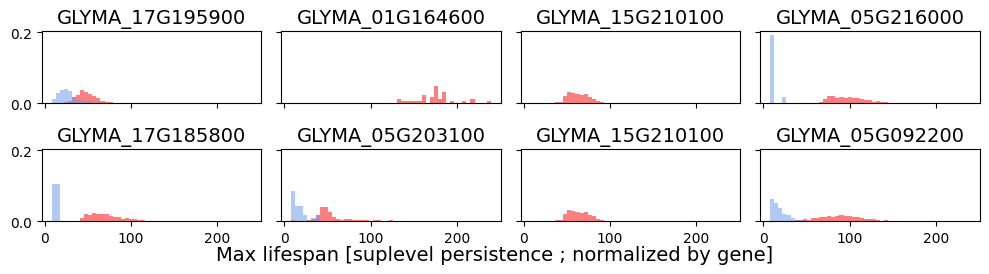

In [53]:
minlife = 8
fs = 14; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']

fig, ax = plt.subplots(2,4, figsize=(10,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

bins = np.linspace(minlife, np.max(maxlife)+1, 50)

for i in range(len(ax)):
    for k in range(maxlife.shape[2]):
        foo = maxlife[i, :, k].ravel()
        if np.sum(foo > minlife) > 0:
            ax[i].hist(foo[foo > minlife], bins=bins, color=color[k], alpha=0.5, label='$H_{}$'.format(k), density=True)
    ax[i].set_title(transcriptomes[Genes[i]], fontsize=fs)

#fig.legend(fontsize=fs)
fig.supxlabel('Max lifespan [{}level persistence ; normalized by {}]'.format(level, normtype), fontsize=fs, y=0.1)
fig.tight_layout();

filename = dst+'max_lifespan_{}level_{}.svg'.format(level, normtype)
#plt.savefig(filename, format='svg', dpi=100, bbox_inches='tight')

In [55]:
diags = [ [ [ rescale*orig_diags[i][j][k].copy()  for k in range(ndims) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]

numpairs, reduced = 0,0

for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][np.diff(diags[i][j][k]).squeeze() > minlife, :].squeeze())
            numpairs += len(diags[i][j][k])
         
        k = argmaxlife[i,j]
        if (len(diags[i][j][k]) == 0) & (len(orig_diags[i][j][k]) > 0):
            diags[i][j][k] = rescale*np.atleast_2d(orig_diags[i][j][k][0])
            numpairs += 1
            reduced +=1
            
print('Post number of life-birth pairs\t:', numpairs)
print('Reduced to null diagrams:\t', reduced)

Post number of life-birth pairs	: 350247
Reduced to null diagrams:	 0


In [57]:
if False:
    isdiag = np.zeros(len(diags[0]), dtype=bool)
    
    for cidx in range(len(isdiag)):
        dk = np.zeros(ndims)
        match = [None for i in range(len(dk))]
        for k in range(len(dk)):
            if (len(diags[0][cidx][k]) > 0) | (len(diags[1][cidx][k]) > 0):
                dk[k], match[k] = persim.bottleneck(diags[0][cidx][k], diags[1][cidx][k], matching=True)
        
        m = match[np.argmax(dk)]
        isdiag[cidx] = -1 in m[np.argmax(m[:,-1]), :]
    
    filename = dst + '{}level_bottleneck_isdiagonal.csv'.format(level)
    np.savetxt(filename, isdiag.reshape(1,-1), delimiter=',', fmt='%d')
    print(filename)

In [56]:
diagh = [ [ None for k in range(ndims) ] for i in range(np.sum(ratios > 0)) ]

counter = 0
for i in range(len(diags)):
    for j in np.nonzero(ratios[i] > 0)[0]:
        for k in range(len(diags[i][j])):
            diagh[counter][k] = diags[i][j][k]
        counter += 1

print(len(diagh), len(diagh[0]), sep='\t')

6433	3


In [62]:
i,j = 0,1
k = 0
dk, mmatch = persim.bottleneck(diagh[i][k], diagh[j][k], matching=True)

In [64]:
mmatch[np.argmax(dk)]

array([ 0.        ,  0.        , 30.50700453])

In [ ]:
initrow = 10
endrow = 12

bottleneck = np.zeros((endrow - initrow, len(diagh)))

ix = 0
for i in range(initrow, endrow, 1):
    for j in range(i+1, bottleneck.shape[1]):
        dk = np.zeros(ndims)
        match = [None for i in range(len(dk))]
        for k in range(len(dk)):
            if (len(diagh[i][k]) > 0) | (len(diagh[j][k]) > 0):
                dk[k], match[k] = persim.bottleneck(diagh[i][k], diagh[j][k], matching=True)
                #dk[k] = ix*j
        bottleneck[ix,j] = np.max(dk)
    ix += 1

In [ ]:
initrow, endrow = 0,9
filename = dst + dst.split(os.sep)[-2] + '_{}level_bottleneck_{:05d}_{:05d}.csv'.format(level, initrow, endrow)
print(filename)
#pd.DataFrame(bottleneck).to_csv(filename, index=False, header=None)

In [66]:
from gtda.diagrams import PersistenceImage

# Bottleneck


In [56]:
np.nonzero(~isdiag)[0]

array([ 11,  34,  60,  92,  96, 111, 117, 138, 157, 185, 197, 208, 232,
       252, 262, 307, 313, 327, 343, 392, 400, 428, 471, 473, 478, 531,
       536, 562, 563, 585, 603, 604, 605, 614, 629, 667, 673, 698, 700,
       707, 717, 727, 742, 777, 787, 819, 820, 834, 865, 894, 904, 911,
       922, 923, 964])

In [74]:
cidx = 340
dk = np.zeros(ndims)
match = [None for i in range(len(dk))]
for k in range(len(dk)):
    if (len(diags[0][cidx][k]) > 0) | (len(diags[1][cidx][k]) > 0):
        dk[k], match[k] = persim.bottleneck(diags[0][cidx][k], diags[1][cidx][k], matching=True)
print(dk, np.round(np.max(dk),1), sep='\n')

[95.47567398  8.37709579  0.        ]
95.5


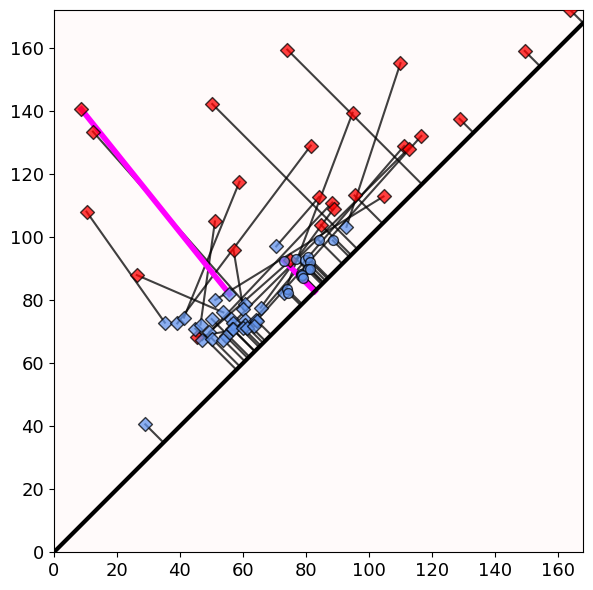

In [73]:
aux = np.max(maxlife[:, cidx, :])
fs = 16; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(2):
    for k in range(ndims):
        if len(diags[j][cidx][k]) > 0:
            ax[i].scatter(diags[j][cidx][k][:,0], diags[j][cidx][k][:,1], alpha=0.75, label='$H_{}$'.format(k), 
                          marker=marker[k], c=color[j], s=50, linewidth=1, edgecolor='k', zorder=k+4)
for k in range(ndims):
    if (match[k] is not None) and (len(match[k]) > 0):
        for m in range(len(match[k])):
            if match[k][m,2] > 0:
                if match[k][m,0] == -1:
                    mid = np.mean(diags[1][cidx][k][ int(match[k][m,1]) ])
                    x1,y1 = mid,mid
                else:
                    x1,y1 = diags[0][cidx][k][ int(match[k][m,0]) ]
                
                if match[k][m,1] == -1:
                    mid = np.mean(diags[0][cidx][k][ int(match[k][m,0]) ])
                    x2,y2 = mid,mid
                else:
                    x2,y2 = diags[1][cidx][k][ int(match[k][m,1]) ]
                if m != np.argmax(match[k][:,2]):
                    ax[i].plot([x1,x2],[y1,y2], c='k', zorder=1, alpha=0.75)
                else:
                    ax[i].plot([x1,x2],[y1,y2], c='magenta', lw=4, zorder=2, alpha=1)
    
ax[i].scatter([0, aux] , [0, aux] , alpha=0)
ax[i].set_aspect('equal')
#ax[i].legend(loc='lower right', fontsize=fs)
ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=3, lw=3)
ax[i].tick_params(labelsize=fs-3)
ax[i].margins(0)
ax[i].set_facecolor('snow')

fig.tight_layout()